
# Data-Centric ML — **Embedding & Clustering Only**
This notebook assumes you already have a CSV (e.g. `dcml_recent_500.csv`) with columns **title** and **abstract**.  
It will:
1. **Embed** each paper with **SPECTER2** (AllenAI).  
2. **Cluster** the embeddings (HDBSCAN by default; optional k-means).  
3. Save: `dcml_specter_embeddings.npy` and `dcml_clustered.csv`.


In [ ]:

!pip -q install pandas numpy tqdm transformers torch scikit-learn hdbscan



## Load your CSV
- Option A: Upload via Colab file widget.  
- Option B: Mount Drive and set the path accordingly.


In [ ]:

# === Option A: Upload manually ===
# from google.colab import files
# uploaded = files.upload()  # then set CSV_PATH to the uploaded filename

# === Option B: Google Drive ===
# from google.colab import drive
# drive.mount('/content/drive')
# CSV_PATH = "/content/drive/MyDrive/dcml/dcml_recent_500.csv"

# === Option C: If already in the runtime ===
CSV_PATH = "dcml_recent_1000.csv"  # change if needed


In [ ]:

import pandas as pd

df = pd.read_csv(CSV_PATH)
required_cols = {"title", "abstract"}
if not required_cols.issubset(set(df.columns.str.lower())):
    # try to align case
    cols_lower = {c.lower(): c for c in df.columns}
    missing = required_cols - set(cols_lower.keys())
    if missing:
        raise ValueError(f"CSV must contain columns: {required_cols}. Found: {list(df.columns)}")
    # rename to standard
    df = df.rename(columns={cols_lower["title"]:"title", cols_lower["abstract"]:"abstract"})

# Basic cleaning
df = df.dropna(subset=["title","abstract"]).copy()
df = df[df["abstract"].astype(str).str.len() > 50].reset_index(drop=True)
print(df.shape)
df.head(2)

(758, 9)


,title,abstract,year,venue,publicationDate,pub_dt,doi,arxivId,url
0,Transforming Healthcare: Intelligent Wearable ...,"Intelligent wearable sensors, empowered by mac...",2025,Advances in Materials,2025-04-01,2025-04-01,10.1002/adma.202500412,NaN,https://www.semanticscholar.org/paper/b03ab3f0...
1,Dive into Time-Series Anomaly Detection: A Dec...,"Recent advances in data collection technology,...",2024,arXiv.org,2024-12-29,2024-12-29,10.48550/arXiv.2412.20512,2412.20512,https://www.semanticscholar.org/paper/5a7747c5...



## Embed with SPECTER2


In [ ]:
import numpy as np, torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

MODEL_NAME = "allenai/specter"  # fallback: "allenai/specter"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

def batch_embed(texts, batch_size=8, max_length=512):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding with SPECTER2"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        with torch.no_grad():
            out = model(**inputs).last_hidden_state[:, 0, :]  # [CLS]
        vecs.append(out.cpu().numpy())
    return np.vstack(vecs)

texts = (df["title"].fillna("") + " " + df["abstract"].fillna("")).tolist()
E = batch_embed(texts, batch_size=8)
np.save("dcml_specter_embeddings.npy", E)
print("Saved embeddings → dcml_specter_embeddings.npy", E.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Embedding with SPECTER2: 100%|██████████| 95/95 [22:16<00:00, 14.07s/it]

Saved embeddings → dcml_specter_embeddings.npy (758, 768)



## Cluster embeddings
- **HDBSCAN** (default): finds dense clusters and marks outliers as -1.  
- **k-means** (optional): pick a fixed `k` or search for best silhouette.


## k-Means Clustering (k=5)

### Subtask:
Führen Sie k-Means Clustering mit 5 Clustern durch und fügen Sie die Ergebnisse zum DataFrame hinzu.

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming E contains the embeddings and df is the DataFrame

# Standardize (no mean shift) - Ensure X is defined
# This part is crucial if X is not guaranteed to be defined from previous cells
if 'E' not in locals():
    try:
        E = np.load("dcml_specter_embeddings.npy")
        print("Embeddings loaded from dcml_specter_embeddings.npy")
    except FileNotFoundError:
        print("Error: Embeddings (E) not found. Please run the embedding cell first.")
        E = None # Ensure E is None if loading fails

if E is not None:
    scaler = StandardScaler(with_mean=False)
    X = scaler.fit_transform(E)

    # Perform KMeans clustering with k=5
    kmeans_k5 = KMeans(n_clusters=5, n_init="auto", random_state=42)
    df['cluster_kmeans_k5'] = kmeans_k5.fit_predict(X)

    # Display the count of papers in each new cluster
    print("KMeans (k=5) Cluster Sizes:")
    print(df['cluster_kmeans_k5'].value_counts().sort_index())

    # Optionally, save the updated dataframe
    # df.to_csv("dcml_clustered_kmeans_k5.csv", index=False)
    # print("Saved k-means (k=5) clusters → dcml_clustered_kmeans_k5.csv")
else:
    print("KMeans clustering skipped because embeddings (E) are not available.")

KMeans (k=5) Cluster Sizes:
cluster_kmeans_k5
0    167
1    308
2     60
3    150
4     73
Name: count, dtype: int64


## Stichwörter für k=5 Cluster

### Subtask:
Extrahieren Sie die Titel und Abstracts für die k=5 Cluster.

In [ ]:
# Ensure df is loaded
if 'df' not in locals() or df is None:
    import pandas as pd
    # Assuming CSV_PATH is defined earlier
    try:
        df = pd.read_csv(CSV_PATH)
        required_cols = {"title", "abstract"}
        if not required_cols.issubset(set(df.columns.str.lower())):
            # try to align case
            cols_lower = {c.lower(): c for c in df.columns}
            missing = required_cols - set(cols_lower.keys())
            if missing:
                raise ValueError(f"CSV must contain columns: {required_cols}. Found: {list(df.columns)}")
            # rename to standard
            df = df.rename(columns={cols_lower["title"]:"title", cols_lower["abstract"]:"abstract"})

        # Basic cleaning
        df = df.dropna(subset=["title","abstract"]).copy()
        df = df[df["abstract"].astype(str).str.len() > 50].reset_index(drop=True)
        print("DataFrame loaded and cleaned.")
    except Exception as e:
        print(f"Error loading or cleaning DataFrame: {e}")
        df = None # Ensure df is None if loading fails

# Ensure 'cluster_kmeans_k5' column exists. This part assumes the KMeans k=5 clustering cell was run successfully.
if df is not None and 'cluster_kmeans_k5' not in df.columns:
    print("Warning: 'cluster_kmeans_k5' column not found in DataFrame. Please run the KMeans k=5 clustering cell.")
    # Attempt to run KMeans k=5 if possible (requires X to be defined)
    if 'X' in locals() and X is not None:
         try:
            from sklearn.cluster import KMeans
            kmeans_k5 = KMeans(n_clusters=5, n_init="auto", random_state=42)
            df['cluster_kmeans_k5'] = kmeans_k5.fit_predict(X)
            print("KMeans (k=5) clustering performed.")
         except Exception as e:
            print(f"Error performing KMeans k=5 clustering: {e}")


if df is not None and 'cluster_kmeans_k5' in df.columns:
    cluster_texts_k5 = {}
    unique_kmeans_k5_clusters = df['cluster_kmeans_k5'].unique()

    for cluster_id in sorted(unique_kmeans_k5_clusters):
        cluster_df = df[df['cluster_kmeans_k5'] == cluster_id]
        cluster_texts_k5[cluster_id] = (cluster_df['title'].fillna("") + " " + cluster_df['abstract'].fillna("")).tolist()

    # Display a sample of the extracted texts for verification
    print("Sample texts for KMeans k=5 clusters:")
    for cluster_id, texts in cluster_texts_k5.items():
        print(f"Cluster {cluster_id} ({len(texts)} documents):")
        for i, text in enumerate(texts[:2]): # Print first 2 texts
            print(f"  - {text[:150]}...")
        print("-" * 20)
        if cluster_id > 2: # Limit output for brevity
            break
else:
    print("DataFrame or 'cluster_kmeans_k5' column not available. Cannot extract cluster texts.")

Sample texts for KMeans k=5 clusters:
Cluster 0 (167 documents):
  - Transforming Healthcare: Intelligent Wearable Sensors Empowered by Smart Materials and Artificial Intelligence Intelligent wearable sensors, empowered...
  - A data-centric machine learning approach to improve prediction of glioma grades using low-imbalance TCGA data Accurate prediction and grading of gliom...
--------------------
Cluster 1 (308 documents):
  - Dive into Time-Series Anomaly Detection: A Decade Review Recent advances in data collection technology, accompanied by the ever-rising volume and velo...
  - Sentiment Analysis of Product Reviews Using Machine Learning and Pre-Trained LLM Sentiment analysis via artificial intelligence, i.e., machine learnin...
--------------------
Cluster 2 (60 documents):
  - A Quantum Circuit-Based Compression Perspective for Parameter-Efficient Learning Quantum-centric supercomputing presents a compelling framework for la...
  - Machine Learning Based Intelligent Management 

### Subtask:
Bereinigen und tokenisieren Sie den Text für die k=5 Cluster.

In [ ]:
# Reuse the preprocess_text function defined earlier

preprocessed_cluster_texts_k5 = {}

if 'cluster_texts_k5' in locals() and cluster_texts_k5:
    for cluster_id, texts in cluster_texts_k5.items():
        preprocessed_cluster_texts_k5[cluster_id] = [preprocess_text(text) for text in texts]

    # Replace original cluster_texts_k5 with preprocessed texts
    cluster_texts_k5 = preprocessed_cluster_texts_k5

    # Display a sample of the preprocessed texts for verification
    print("Sample preprocessed texts for KMeans k=5 clusters:")
    for cluster_id, texts in cluster_texts_k5.items():
        print(f"Cluster {cluster_id} ({len(texts)} documents):")
        for i, text_tokens in enumerate(texts[:2]): # Print first 2 preprocessed texts
            print(f"  - {' '.join(text_tokens[:20])}...") # Print first 20 tokens
        print("-" * 20)
        if cluster_id > 2: # Limit output for brevity
            break
else:
    print("Variable 'cluster_texts_k5' not found or is empty. Please run the cell to extract texts by cluster for k=5 (e.g., cell 4538693d) before running this cell.")

NameError: name 'preprocess_text' is not defined

### Subtask:
Verwenden Sie TF-IDF, um die wichtigsten Stichwörter für die k=5 Cluster zu identifizieren.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np # Ensure numpy is imported

# Ensure cluster_texts_k5 is populated from the previous step
if 'cluster_texts_k5' in locals() and cluster_texts_k5:
    cluster_keywords_k5 = {}
    N = 10  # Number of top keywords to extract per cluster

    # Prepare documents for TF-IDF: each cluster is a single "document" of joined tokens
    cluster_docs_k5 = [" ".join([" ".join(doc) for doc in cluster_texts_k5[cluster_id]]) for cluster_id in sorted(cluster_texts_k5.keys())]

    # Initialize TF-IDF Vectorizer
    # We can use the preprocessed tokens directly by setting tokenizer and preprocessor to None
    # and ensuring the input is a list of strings (which cluster_docs_k5 is after joining tokens)
    # min_df and max_df can help filter out too rare or too common terms
    vectorizer_k5 = TfidfVectorizer(min_df=2, max_df=0.95)

    # Fit and transform the cluster documents
    try:
        tfidf_matrix_k5 = vectorizer_k5.fit_transform(cluster_docs_k5)

        # Check if vocabulary is empty after fitting
        if not vectorizer_k5.get_feature_names_out().size:
             print("ValueError: empty vocabulary; perhaps the documents only contain stop words or are too short after preprocessing.")
        else:
            # Get feature names (words)
            feature_names_k5 = vectorizer_k5.get_feature_names_out()

            # Extract top keywords for each cluster
            for i, cluster_id in enumerate(sorted(cluster_texts_k5.keys())):
                # Get TF-IDF scores for the current cluster
                tfidf_scores_k5 = tfidf_matrix_k5[i].toarray().flatten()

                # Get indices of top N scores
                top_n_indices_k5 = tfidf_scores_k5.argsort()[-N:][::-1]

                # Get top N keywords and their scores
                top_keywords_with_scores_k5 = [(feature_names_k5[j], tfidf_scores_k5[j]) for j in top_n_indices_k5]

                # Store just the keywords
                cluster_keywords_k5[cluster_id] = [keyword for keyword, score in top_keywords_with_scores_k5]

            # Print the top keywords for each cluster
            print("\nTop Keywords per Cluster (KMeans k=5):")
            for cluster_id, keywords in cluster_keywords_k5.items():
                print(f"Cluster {cluster_id}: {', '.join(keywords)}")

    except ValueError as e:
        print(f"Error during TF-IDF calculation: {e}")

else:
    print("cluster_texts_k5 is not available or empty. Cannot perform TF-IDF.")

Error during TF-IDF calculation: empty vocabulary; perhaps the documents only contain stop words


## Visualisierung für k=5 Cluster

### Subtask:
Visualisieren Sie die k=5 Cluster mit UMAP.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd # Ensure pandas is imported

# Assuming df contains 'umap_x', 'umap_y' and 'cluster_kmeans_k5' columns

# Ensure df is loaded and umap columns exist
if 'df' not in locals() or df is None:
    print("DataFrame not loaded. Please run the data loading and UMAP reduction cells.")
elif 'umap_x' not in df.columns or 'umap_y' not in df.columns:
     print("UMAP columns ('umap_x', 'umap_y') not found in DataFrame. Please run the UMAP reduction cell.")
elif 'cluster_kmeans_k5' not in df.columns:
     print("'cluster_kmeans_k5' column not found in DataFrame. Please run the KMeans k=5 clustering cell.")
else:
    # Visualize KMeans k=5 clusters using a categorical palette with shuffled colors
    plt.figure(figsize=(12, 8))
    num_kmeans_k5_clusters = df['cluster_kmeans_k5'].nunique()
    # Use a categorical palette and shuffle the colors
    palette_k5 = sns.color_palette("hsv", num_kmeans_k5_clusters)
    random.seed(42) # for reproducibility
    random.shuffle(palette_k5)

    sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster_kmeans_k5', palette=palette_k5, s=10, legend='full')
    plt.title('KMeans Clusters (k=5) visualized with UMAP (Categorical Colors - Shuffled)')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

UMAP columns ('umap_x', 'umap_y') not found in DataFrame. Please run the UMAP reduction cell.


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming E contains the embeddings and df is the DataFrame

# Standardize (no mean shift) - Ensure X is defined
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(E)


# Perform KMeans clustering with k=5
kmeans_k5 = KMeans(n_clusters=5, n_init="auto", random_state=42)
df['cluster_kmeans_k5'] = kmeans_k5.fit_predict(X)

# Display the count of papers in each new cluster
print("KMeans (k=5) Cluster Sizes:")
print(df['cluster_kmeans_k5'].value_counts().sort_index())

# Optionally, save the updated dataframe
# df.to_csv("dcml_clustered_kmeans_k5.csv", index=False)
# print("Saved k-means (k=5) clusters → dcml_clustered_kmeans_k5.csv")

KMeans (k=5) Cluster Sizes:
cluster_kmeans_k5
0    167
1    308
2     60
3    150
4     73
Name: count, dtype: int64


In [ ]:

from sklearn.preprocessing import StandardScaler
import hdbscan

# Standardize (no mean shift)
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(E)

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(X)
df["cluster"] = labels

n_clusters = len(set(labels) - {-1})
noise_frac = (labels == -1).mean()
print(f"HDBSCAN → clusters: {n_clusters} (noise: {noise_frac:.2%})")

df.to_csv("dcml_clustered.csv", index=False)
print("Saved clusters → dcml_clustered.csv")


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN → clusters: 0 (noise: 100.00%)
Saved clusters → dcml_clustered.csv


In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
best_k, best_score = None, -1
for k in range(6, 21):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)
    score = silhouette_score(X, km.labels_)
    if score > best_score:
        best_k, best_score = k, score
print(f"Best k by silhouette: {best_k} (score={best_score:.3f})")
km = KMeans(n_clusters=best_k or 10, n_init="auto", random_state=42).fit(X)
df['cluster_kmeans'] = km.labels_
df.to_csv("dcml_clustered_kmeans.csv", index=False)
print("Saved k-means clusters → dcml_clustered_kmeans.csv")


Best k by silhouette: 7 (score=0.058)
Saved k-means clusters → dcml_clustered_kmeans.csv


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Assuming df contains 'cluster' and 'cluster_kmeans' columns and E contains the embeddings

def get_cluster_stats_and_representatives(dataframe, embeddings, cluster_column):
    """
    Calculates statistics for each cluster and finds a representative paper.

    Args:
        dataframe (pd.DataFrame): DataFrame with cluster labels.
        embeddings (np.ndarray): Array of embeddings.
        cluster_column (str): Name of the column containing cluster labels.

    Returns:
        dict: A dictionary where keys are cluster labels and values are dictionaries
              containing 'size' and 'representative_paper' (title and abstract).
    """
    cluster_info = {}
    unique_clusters = dataframe[cluster_column].unique()

    for cluster_id in sorted(unique_clusters):
        if cluster_id == -1 and cluster_column == 'cluster':
            # Skip noise cluster for HDBSCAN representative
            continue

        cluster_df = dataframe[dataframe[cluster_column] == cluster_id].copy()
        cluster_indices = cluster_df.index.tolist()
        cluster_embeddings = embeddings[cluster_indices]

        # Calculate cluster size
        cluster_size = len(cluster_df)

        representative_paper = None
        if cluster_size > 0:
            # Calculate centroid of the cluster embeddings
            centroid = np.mean(cluster_embeddings, axis=0)

            # Find the paper closest to the centroid
            distances_to_centroid = cdist([centroid], cluster_embeddings, metric='euclidean')[0]
            closest_index_in_cluster = np.argmin(distances_to_centroid)
            original_index = cluster_indices[closest_index_in_cluster]
            representative_paper = {
                "title": dataframe.loc[original_index, 'title'],
                "abstract": dataframe.loc[original_index, 'abstract']
            }

        cluster_info[cluster_id] = {
            "size": cluster_size,
            "representative_paper": representative_paper
        }

    return cluster_info

# Get stats and representatives for HDBSCAN clusters
hdbscan_cluster_stats = get_cluster_stats_and_representatives(df, E, 'cluster')
print("HDBSCAN Cluster Statistics and Representatives:")
for cluster_id, info in hdbscan_cluster_stats.items():
    print(f"Cluster {cluster_id}: Size = {info['size']}")
    if info['representative_paper']:
        print(f"  Representative Paper Title: {info['representative_paper']['title']}")
        print(f"  Representative Paper Abstract: {info['representative_paper']['abstract'][:200]}...") # Print first 200 chars
    else:
        print("  No representative paper (cluster is empty or noise)")
    print("-" * 20)


# Get stats and representatives for KMeans clusters
kmeans_cluster_stats = get_cluster_stats_and_representatives(df, E, 'cluster_kmeans')
print("\nKMeans Cluster Statistics and Representatives:")
for cluster_id, info in kmeans_cluster_stats.items():
    print(f"Cluster {cluster_id}: Size = {info['size']}")
    if info['representative_paper']:
        print(f"  Representative Paper Title: {info['representative_paper']['title']}")
        print(f"  Representative Paper Abstract: {info['representative_paper']['abstract'][:200]}...") # Print first 200 chars
    else:
        print("  No representative paper (cluster is empty)")
    print("-" * 20)

HDBSCAN Cluster Statistics and Representatives:

KMeans Cluster Statistics and Representatives:
Cluster 0: Size = 72
  Representative Paper Title: Homological Convolutional Neural Networks
  Representative Paper Abstract: Deep learning methods have demonstrated outstanding performances on classification and regression tasks on homogeneous data types (e.g., image, audio, and text data). However, tabular data still pose ...
--------------------
Cluster 1: Size = 218
  Representative Paper Title: Navigating Data-Centric Artificial Intelligence With DC-Check: Advances, Challenges, and Opportunities
  Representative Paper Abstract: Data-centric artificial intelligence (AI) is an emerging paradigm that emphasizes the critical role of data in real-world machine learning (ML) systems—as a complement to model development. However, d...
--------------------
Cluster 2: Size = 53
  Representative Paper Title: The Landscape of Compute-near-memory and Compute-in-memory: A Research and Commercial Ove

In [ ]:
!pip install umap-learn matplotlib seaborn

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


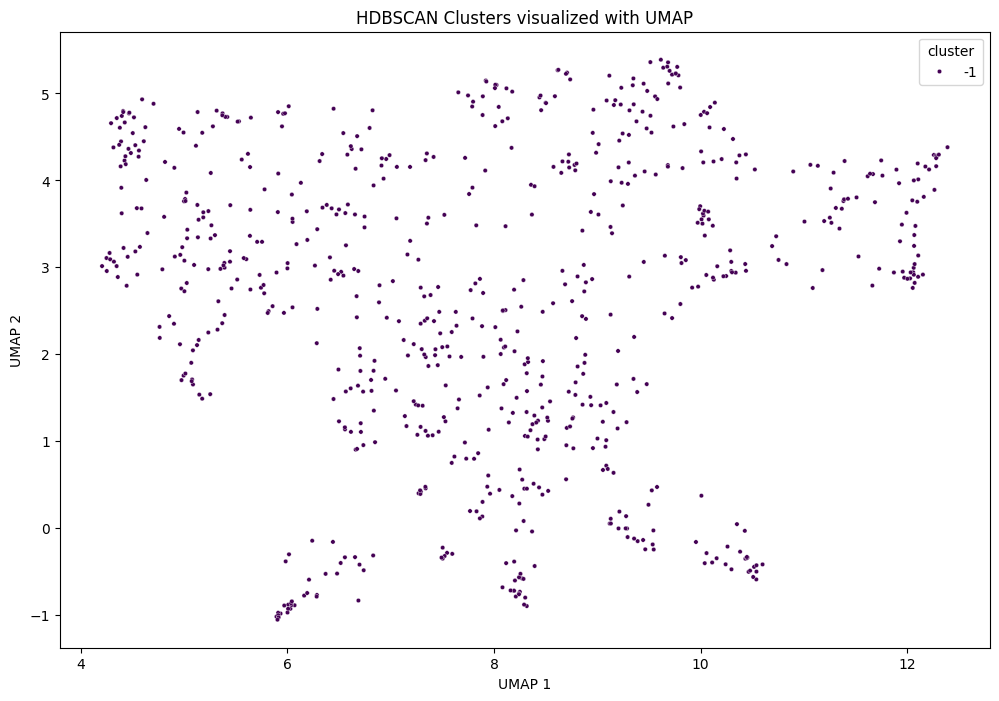

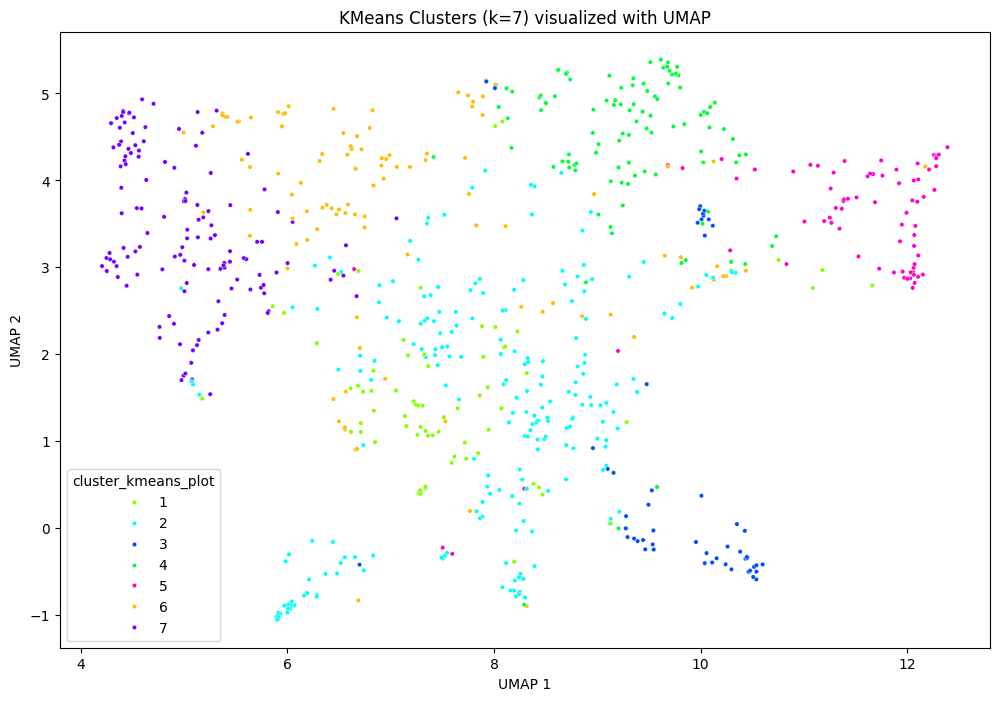

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

# Load embeddings if not already in memory (optional, assuming E is available)
# E = np.load("dcml_specter_embeddings.npy")

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(E)

# Add UMAP coordinates to the dataframe
df['umap_x'] = umap_embeddings[:, 0]
df['umap_y'] = umap_embeddings[:, 1]

# Visualize HDBSCAN clusters (using a simple palette as there's only noise)
plt.figure(figsize=(12, 8))
# Since HDBSCAN resulted in only noise (-1), a simple color distinguishes noise from potential future clusters
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster', palette='viridis', s=10, legend='full')
plt.title('HDBSCAN Clusters visualized with UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Add a new column for KMeans clusters shifted by 1 for plotting
df['cluster_kmeans_plot'] = df['cluster_kmeans'] + 1

# Visualize KMeans clusters using a categorical palette with shuffled colors (as requested previously)
plt.figure(figsize=(12, 8))
num_kmeans_clusters = df['cluster_kmeans_plot'].nunique()
# Use a categorical palette and shuffle the colors
palette = sns.color_palette("hsv", num_kmeans_clusters)
random.seed(42) # for reproducibility
random.shuffle(palette)

sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster_kmeans_plot', palette=palette, s=10, legend='full')
plt.title('KMeans Clusters (k=7) visualized with UMAP') # Changed title
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

UMAP coordinates already found in DataFrame.


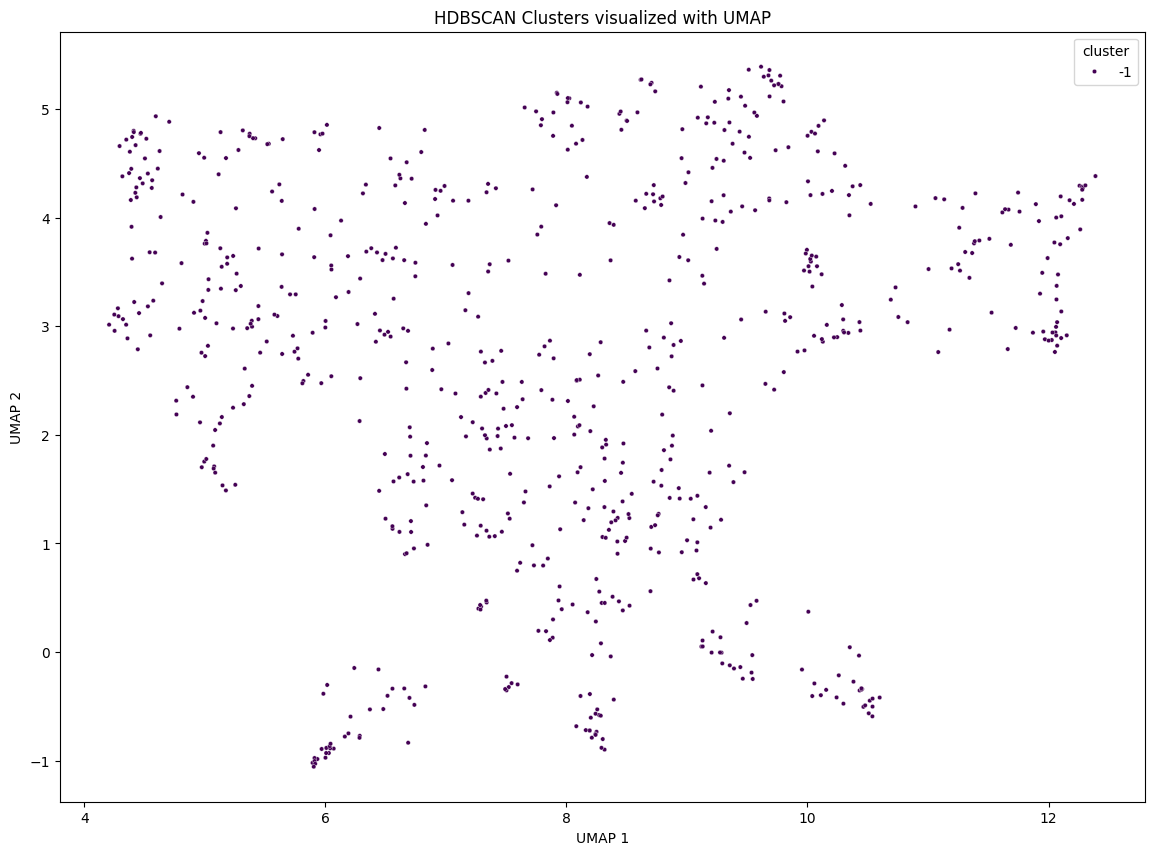

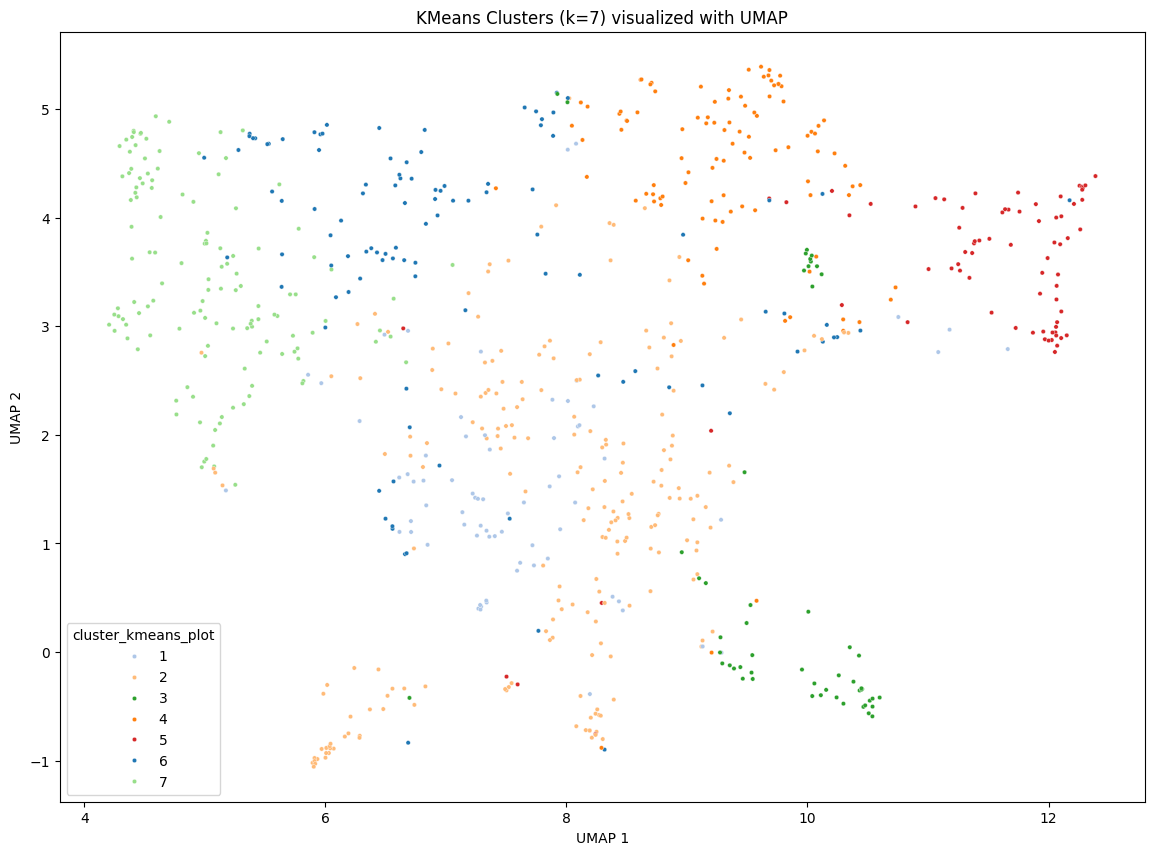

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

# Assuming E contains the embeddings and df contains 'cluster' and 'cluster_kmeans'

# Reduce dimensionality with UMAP if not already done
if 'umap_x' not in df.columns or 'umap_y' not in df.columns:
    print("Performing UMAP dimensionality reduction...")
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_embeddings = reducer.fit_transform(E)
    df['umap_x'] = umap_embeddings[:, 0]
    df['umap_y'] = umap_embeddings[:, 1]
    print("UMAP reduction complete.")
else:
    print("UMAP coordinates already found in DataFrame.")


# Visualize HDBSCAN clusters
plt.figure(figsize=(14, 10)) # Increased figure size
# Since HDBSCAN resulted in only noise (-1), a simple color distinguishes noise from potential future clusters
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster', palette='viridis', s=10, legend='full')
plt.title('HDBSCAN Clusters visualized with UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Add a new column for KMeans clusters shifted by 1 for plotting
df['cluster_kmeans_plot'] = df['cluster_kmeans'] + 1

# Visualize KMeans clusters using a categorical palette with shuffled colors (as requested)
plt.figure(figsize=(14, 10)) # Increased figure size
num_kmeans_clusters = df['cluster_kmeans_plot'].nunique()
# Use a different categorical palette with hopefully higher contrast and shuffle the colors
palette = sns.color_palette("tab20", num_kmeans_clusters) # Using tab20 palette
random.seed(42) # for reproducibility
random.shuffle(palette)

sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster_kmeans_plot', palette=palette, s=10, legend='full')
plt.title('KMeans Clusters (k=7) visualized with UMAP') # Changed title
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Task
Extract representative keywords for each cluster from the provided text data.

## Textdaten nach clustern sammeln

### Subtask:
Extrahieren Sie die Titel und Abstracts für jedes Cluster.


In [ ]:
cluster_texts = {}
unique_kmeans_clusters = df['cluster_kmeans'].unique()

for cluster_id in sorted(unique_kmeans_clusters):
    cluster_df = df[df['cluster_kmeans'] == cluster_id]
    cluster_texts[cluster_id] = (cluster_df['title'].fillna("") + " " + cluster_df['abstract'].fillna("")).tolist()

# Display a sample of the extracted texts for verification
for cluster_id, texts in cluster_texts.items():
    print(f"Cluster {cluster_id} ({len(texts)} documents):")
    for i, text in enumerate(texts[:2]): # Print first 2 texts
        print(f"  - {text[:150]}...")
    print("-" * 20)
    if cluster_id > 2: # Limit output for brevity
        break

Cluster 0 (72 documents):
  - Sentiment Analysis of Product Reviews Using Machine Learning and Pre-Trained LLM Sentiment analysis via artificial intelligence, i.e., machine learnin...
  - AIFS -- ECMWF's data-driven forecasting system Machine learning-based weather forecasting models have quickly emerged as a promising methodology for a...
--------------------
Cluster 1 (218 documents):
  - Weak-to-Strong Generalization Through the Data-Centric Lens The weak-to-strong generalization phenomenon is the driver for important machine learning ...
  - Federated Learning: Navigating the Landscape of Collaborative Intelligence As data become increasingly abundant and diverse, their potential to fuel m...
--------------------
Cluster 2 (53 documents):
  - A Quantum Circuit-Based Compression Perspective for Parameter-Efficient Learning Quantum-centric supercomputing presents a compelling framework for la...
  - Machine Learning Based Intelligent Management System for Energy Storage Using Computi

## Textvorverarbeitung

### Subtask:
Bereinigen und tokenisieren Sie den Text für jedes Cluster.


In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

# Download NLTK data (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Converts text to lowercase, removes punctuation, tokenizes, removes stopwords, and lemmatizes."""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = text.split()
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to texts in each cluster
preprocessed_cluster_texts = {}
for cluster_id, texts in cluster_texts.items():
    preprocessed_cluster_texts[cluster_id] = [preprocess_text(text) for text in texts]

# Replace original cluster_texts with preprocessed texts
cluster_texts = preprocessed_cluster_texts

# Display a sample of the preprocessed texts for verification
for cluster_id, texts in cluster_texts.items():
    print(f"Cluster {cluster_id} ({len(texts)} documents):")
    for i, text_tokens in enumerate(texts[:2]): # Print first 2 preprocessed texts
        print(f"  - {' '.join(text_tokens[:20])}...") # Print first 20 tokens
    print("-" * 20)
    if cluster_id > 2: # Limit output for brevity
        break

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Cluster 0 (72 documents):
  - sentiment analysis product review using machine learning pretrained llm sentiment analysis via artificial intelligence ie machine learning large language model...
  - aifs ecmwfs datadriven forecasting system machine learningbased weather forecasting model quickly emerged promising methodology accurate mediumrange global weather forecasting introduce...
--------------------
Cluster 1 (218 documents):
  - weaktostrong generalization datacentric lens weaktostrong generalization phenomenon driver important machine learning application including highly dataefficient learning recently performing superalignment decade...
  - federated learning navigating landscape collaborative intelligence data become increasingly abundant diverse potential fuel machine learning model increasingly vast however traditional...
--------------------
Cluster 2 (53 documents):
  - quantum circuitbased compression perspective parameterefficient learning quantumcentric supercomputing p

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

# Download NLTK data (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Converts text to lowercase, removes punctuation, tokenizes, removes stopwords, and lemmatizes."""
    # Check if text is already a list (likely preprocessed)
    if isinstance(text, list):
        return text

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    tokens = text.split()
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to texts in each cluster
preprocessed_cluster_texts = {}

if 'cluster_texts' in locals() and cluster_texts:
    for cluster_id, texts in cluster_texts.items():
        preprocessed_cluster_texts[cluster_id] = [preprocess_text(text) for text in texts]

    # Replace original cluster_texts with preprocessed texts
    cluster_texts = preprocessed_cluster_texts

    # Display a sample of the preprocessed texts for verification
    print("Sample preprocessed texts for KMeans clusters:")
    for cluster_id, texts in cluster_texts.items():
        print(f"Cluster {cluster_id} ({len(texts)} documents):")
        for i, text_tokens in enumerate(texts[:2]): # Print first 2 preprocessed texts
            print(f"  - {' '.join(text_tokens[:20])}...") # Print first 20 tokens
        print("-" * 20)
        if cluster_id > 2: # Limit output for brevity
            break
else:
    print("Variable 'cluster_texts' not found or is empty. Please run the cell to extract texts by cluster (e.g., cell ce45f313) before running this cell.")

Sample preprocessed texts for KMeans clusters:
Cluster 0 (72 documents):
  - sentiment analysis product review using machine learning pretrained llm sentiment analysis via artificial intelligence ie machine learning large language model...
  - aifs ecmwfs datadriven forecasting system machine learningbased weather forecasting model quickly emerged promising methodology accurate mediumrange global weather forecasting introduce...
--------------------
Cluster 1 (218 documents):
  - weaktostrong generalization datacentric lens weaktostrong generalization phenomenon driver important machine learning application including highly dataefficient learning recently performing superalignment decade...
  - federated learning navigating landscape collaborative intelligence data become increasingly abundant diverse potential fuel machine learning model increasingly vast however traditional...
--------------------
Cluster 2 (53 documents):
  - quantum circuitbased compression perspective parametereff

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(E)

## Stichwortextraktion

### Subtask:
Verwenden Sie eine Methode wie TF-IDF oder Häufigkeitsanalyse, um die wichtigsten Stichwörter für jedes Cluster zu identifizieren.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

cluster_keywords = {}
N = 10  # Number of top keywords to extract per cluster

# Prepare documents for TF-IDF: each cluster is a single "document" of joined tokens
cluster_docs = [" ".join([" ".join(doc) for doc in cluster_texts[cluster_id]]) for cluster_id in sorted(cluster_texts.keys())]

# Initialize TF-IDF Vectorizer
# We can use the preprocessed tokens directly by setting tokenizer and preprocessor to None
# and ensuring the input is a list of strings (which cluster_docs is after joining tokens)
# min_df and max_df can help filter out too rare or too common terms
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)

# Fit and transform the cluster documents
tfidf_matrix = vectorizer.fit_transform(cluster_docs)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Extract top keywords for each cluster
for i, cluster_id in enumerate(sorted(cluster_texts.keys())):
    # Get TF-IDF scores for the current cluster
    tfidf_scores = tfidf_matrix[i].toarray().flatten()

    # Get indices of top N scores
    top_n_indices = tfidf_scores.argsort()[-N:][::-1]

    # Get top N keywords and their scores
    top_keywords_with_scores = [(feature_names[j], tfidf_scores[j]) for j in top_n_indices]

    # Store just the keywords
    cluster_keywords[cluster_id] = [keyword for keyword, score in top_keywords_with_scores]

# Print the top keywords for each cluster
print("Top Keywords per Cluster (KMeans):")
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")


Top Keywords per Cluster (KMeans):
Cluster 0: language, text, translation, sentiment, graph, medium, emotion, ood, tabular, email
Cluster 1: material, explanation, healthcare, analytics, objectcentric, graph, privacy, business, object, datadriven
Cluster 2: memory, energy, quantum, hardware, graph, device, cpu, movement, computation, virtual
Cluster 3: iot, fl, wireless, device, federated, traffic, privacy, attack, metaverse, networking
Cluster 4: weather, agriculture, air, climate, urban, mediumrange, wind, ensemble, hyperspectral, rmse
Cluster 5: health, healthcare, disease, sensor, patient, wearable, heart, care, anomaly, diabetes
Cluster 6: patient, clinical, disease, auc, mortality, medical, cancer, risk, mri, healthcare


## Ergebnisse anzeigen

### Subtask:
Präsentieren Sie die gefundenen Stichwörter für jedes Cluster.


**Reasoning**:
Iterate through the cluster_keywords dictionary and print the cluster ID and its keywords.



In [ ]:
# Present the extracted keywords for each cluster
print("Extracted Keywords for Each Cluster (KMeans):")
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")